- RNN
  - 가중치를 반복사용해서 시계열 데이터(시간의 순서)를 다루는 모델  
  - 순서대로 특징을 추출
  - 과거정보와 현재정보를 모두 갖고 있어야 함
     - 모델이 내보낸 과거정보를 다시 입력으로 넣어주어야 함
- 최대-최소 정규화
  - 최대값이 1이되도록 값의 범위를 바꿔주는 기법

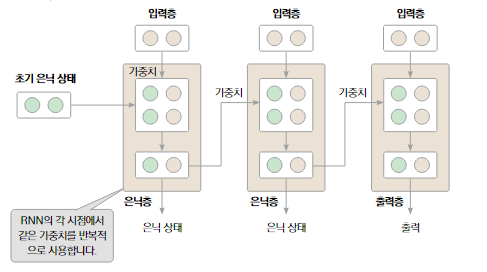

In [1]:
!unzip 'netflix.zip'

Archive:  netflix.zip
  inflating: NFLX.csv                


In [2]:
import pandas as pd
data = pd.read_csv('NFLX.csv')
data.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800


In [3]:
# open: 개장가, Hight : 장중 최고가, Low : 장중 최저가 , Close:종가 Volume : 거래량  Adj Close:분할,배당등의 조정사항 적용한 종가

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1009 non-null   object 
 1   Open       1009 non-null   float64
 2   High       1009 non-null   float64
 3   Low        1009 non-null   float64
 4   Close      1009 non-null   float64
 5   Adj Close  1009 non-null   float64
 6   Volume     1009 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.3+ KB


In [5]:
import matplotlib.pyplot as plt

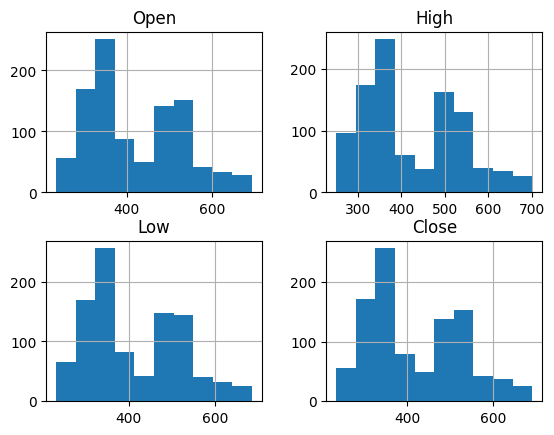

In [6]:
data_used = data.iloc[:, 1:5]
data_used.hist()
plt.show()

딥러닝에서는 오차역전파를 이용해서 학습, 출력의 범위가 넓으면 즉 값이 커지면 오차 범위가 커지고, 오차가 커지면 기울기가 커지고 가중치계산에 안 좋은 영향을 미침
  - 값의 범위를 조정 0~1 정규화 best
  - 최소-최대 정규화
    - 이상치에 민감함

In [7]:
data_used.describe()

,Open,High,Low,Close
count,1009.000000,1009.000000,1009.000000,1009.000000
mean,419.059673,425.320703,412.374044,419.000733
std,108.537532,109.262960,107.555867,108.289999
min,233.919998,250.649994,231.229996,233.880005
25%,331.489990,336.299988,326.000000,331.619995
50%,377.769989,383.010010,370.880005,378.670013
75%,509.130005,515.630005,502.529999,509.079987
max,692.349976,700.989990,686.090027,691.690002


<Axes: >

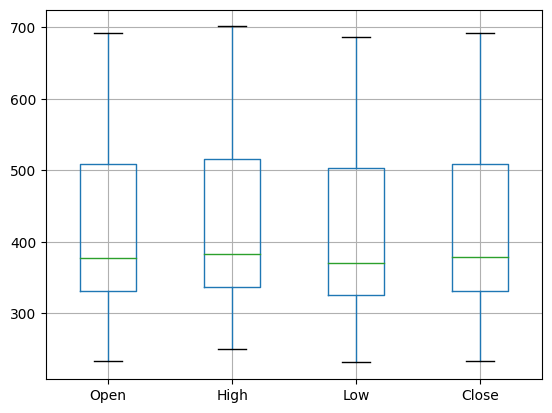

In [8]:
data_used.boxplot()

In [9]:
data.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800


In [10]:
import numpy as np
from torch.utils.data.dataset import Dataset
class NetFlix(Dataset):
  def __init__(self):
    # 데이터 읽기
    self.csv = pd.read_csv('NFLX.csv')
    # 입력 데이터 정규화
    self.data = self.csv.iloc[:, 1:4].values
    self.data = self.data / np.max(self.data)

    # 종가 데이터 정규화
    self.label =  self.csv['Close'].values
    self.label = self.label / np.max(self.label)
  def __len__(self):
    return len(self.data) - 30 # 사용 가능한 배치 개수
  def __getitem__(self, index):
    # 30일치가 기준
    data = self.data[index : index+30 ]
    label =self.label[index+30 ]
    return data, label


In [11]:
import numpy as np

np.array([1,2,3,4]) / 4

array([0.25, 0.5 , 0.75, 1.  ])

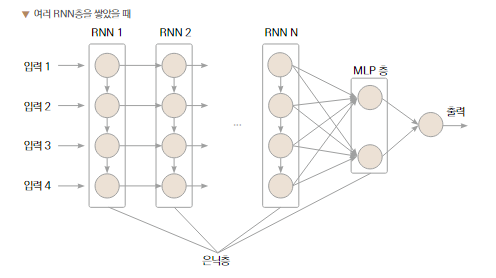

In [12]:
import torch
import torch.nn as nn
class RNN(nn.Module):
  def __init__(self):
    super(RNN,self).__init__()
    # rnn 층 정의
    # num_layers : 쌓는 rnn 개수 많으면 기울기소실 또는 기울기 무한대가 되는.. 기울기 폭발현상
    # 일반적으로 5개나 3개
    # batch_first : 데이터의 구조 shape 에서 배치차원이 가장 앞에 오도록 수정
    # (30,3) --> 배치크기가 32개이면.. (32,30,3)
    self.rnn = nn.RNN(input_size=3, hidden_size=8, num_layers=5,batch_first=True)

    # 분류기
    self.fc1 = nn.Linear(in_features=240, out_features=64)
    self.fc2 = nn.Linear(in_features=64, out_features=1)
    self.relu = nn.ReLU()

  def forward(self,x, h):
    x, hn = self.rnn(x,h)  # rnn층 출력

    # 분류기의 입력으로 사용되게 모양 변경
    x = torch.reshape(x, (x.shape[0], -1 ))

    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)

    # 예측한 종가를 1차원 벡터로 변환
    x = torch.flatten(x)

    return x

In [13]:
import tqdm
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = RNN().to(device)
dataset = NetFlix()
loader = DataLoader(dataset, batch_size=32)
optim = Adam(model.parameters(), lr=1e-4)

for epoch in range(100):
  iter = tqdm.tqdm(loader)
  for data,label in iter:
    optim.zero_grad()
    # 초기 은닉상는 모든 요소가 0으로 구성된 텐서로 설정 (rnn은닉층개수,배치크기,출력차원)
    h = torch.zeros(5,data.shape[0],8).to(device)
    # 예측값
    pred =  model(data.type(torch.FloatTensor).to(device), h)
    # 손실
    loss = nn.MSELoss()(pred,label.type(torch.FloatTensor).to(device))
    # 오차 역전파
    loss.backward()
    # 최적화
    optim.step()
    iter.set_description(f"epoch{epoch} loss:{loss.item()}")
torch.save(model.state_dict(), 'RNN.pth')


epoch99 loss:0.02818267047405243: 100%|██████████| 31/31 [00:00<00:00, 153.11it/s]


모델 성능 평가

In [14]:
loader = DataLoader(dataset,batch_size=1)
preds = []
total_loss = 0
with torch.no_grad():
  model.load_state_dict(torch.load('RNN.pth', map_location=device))
  for data,label in loader:
    h = torch.zeros(5,data.shape[0],8).to(device)
    # 예측값
    pred =  model(data.type(torch.FloatTensor).to(device), h)
    preds.append(pred.item()) # 예측값을 리스트에 추가
    # 손실
    loss = nn.MSELoss()( pred,label.type(torch.FloatTensor).to(device) )
    # loss = torch.mean(torch.abs(pred - label))

    # 손실 평균치 계산
    total_loss += loss / len(loader)

print(total_loss.item())
# 0.039577988185248804

0.002380525227636099


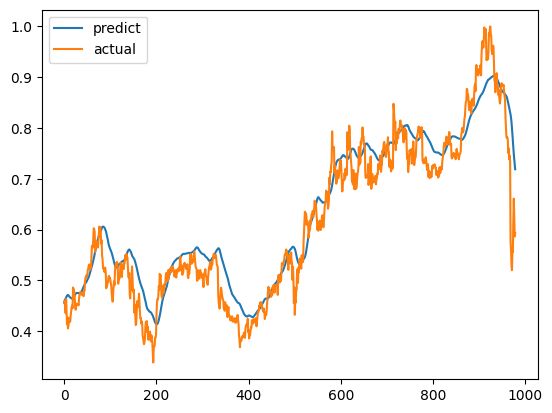

In [15]:
plt.plot(preds, label="predict")
plt.plot(dataset.label[30:], label="actual")
plt.legend()
plt.show()

In [16]:
1e-4

0.0001